In [1]:
import logging
import multiprocessing as mp
import os
import random as rn
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import Normalizer
from zoo import init_spark_on_local
from zoo.automl.config.recipe import BayesRecipe, LSTMGridRandomRecipe
from zoo.automl.regression.time_sequence_predictor import TimeSequencePredictor
from zoo.ray import RayContext

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    rn.seed(seed)
    tf.set_random_seed(seed)

Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.10.0-spark_2.4.3-0.8.1-jar-with-dependencies.jar to BIGDL_JARS
Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


[*********************100%***********************]  1 of 1 completed
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
(1000, 7) 0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-08-26,769.000000,776.080017,765.849976,769.539978,769.539978,1166700
2016-08-29,768.739990,774.989990,766.614990,772.150024,772.150024,847600
2016-08-30,769.330017,774.466003,766.840027,769.090027,769.090027,1130000
2016-08-31,767.010010,769.090027,765.380005,767.049988,767.049988,1248600
2016-09-01,769.250000,771.020020,764.299988,768.780029,768.780029,925100
...,...,...,...,...,...,...
2020-08-11,1492.439941,1510.000000,1478.000000,1480.319946,1480.319946,1454400
2020-08-12,1485.579956,1512.385986,1485.250000,1506.619995,1506.619995,1437700
2020-08-13,1510.339966,1537.250000,1508.005005,1518.449951,1518.449951,1455200


(1453, 1) 0


,Adj Close
Date,
2016-08-26,769.539978
2016-08-27,770.409993
2016-08-28,771.280009
2016-08-29,772.150024
2016-08-30,769.090027
...,...
2020-08-13,1518.449951
2020-08-14,1507.729980
2020-08-15,1511.146647


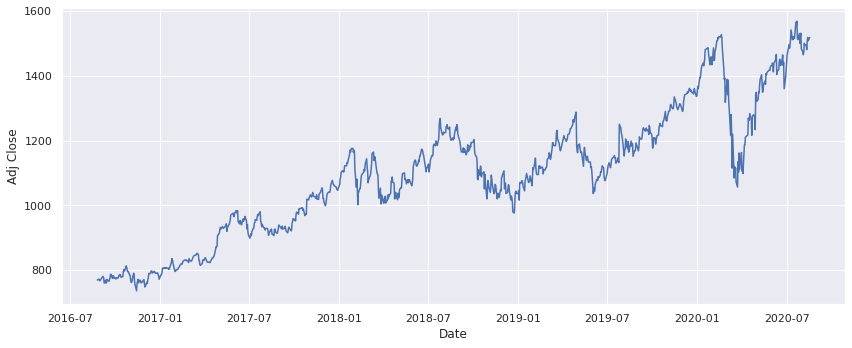

In [2]:
# data = pd.read_csv("AirPassengers.csv")
# data = pd.read_csv("data/nyc_energy.csv")[:-81][:1000]
# data = pd.read_csv("data/nyc_taxi.csv")[:2000]
data = yf.download("GOOG").reset_index()[-1000:]
# data = pd.read_csv("data/temperature.csv")[1:-792]

print(data.columns)

# target = "#Passengers"
# dt, target = "timeStamp", "demand"
# target = "value"
dt, target = "Date", "Adj Close"
# target = "Tel Aviv District"
print(data.shape, data[target].isna().sum())

data[dt] = pd.to_datetime(data[dt])
data = data.set_index(dt)
display(data)
data = data[[target]]
data = data.resample("d").mean().interpolate()
print(data.shape, data[target].isna().sum())

plt.figure(figsize=(12, 5))
sns.lineplot(x=data.index, y=target, data=data)
plt.tight_layout()
plt.show()

In [3]:
x_train, x_test, y_train, y_test = train_test_split(data.index.values, data[target].values,
                                                    shuffle=False, test_size=.2)
# x_train = x_train.reshape(-1, 1)
# x_test = x_test.reshape(-1, 1)

# y_train_mean = np.mean(y_train)
# y_train_std = np.std(y_train)
# y_train = (y_train - y_train_mean) / y_train_std
# y_test = (y_test - y_train_mean) / y_train_std

df_train = pd.DataFrame({dt: x_train, target: y_train})
df_test = pd.DataFrame({dt: x_test, target: y_test})
display(df_train, df_test)

,Date,Adj Close
0,2016-08-26,769.539978
1,2016-08-27,770.409993
2,2016-08-28,771.280009
3,2016-08-29,772.150024
4,2016-08-30,769.090027
...,...,...
1157,2019-10-27,1281.710002
1158,2019-10-28,1290.000000
1159,2019-10-29,1262.619995
1160,2019-10-30,1261.290039


,Date,Adj Close
0,2019-11-01,1273.739990
1,2019-11-02,1279.616659
2,2019-11-03,1285.493327
3,2019-11-04,1291.369995
4,2019-11-05,1292.030029
...,...,...
286,2020-08-13,1518.449951
287,2020-08-14,1507.729980
288,2020-08-15,1511.146647
289,2020-08-16,1514.563314


In [4]:
sc = init_spark_on_local(cores=mp.cpu_count(), spark_log_level="ERROR", redirect_spark_log=False)
ray_ctx = RayContext(sc=sc)
ray_ctx.init()
tsp = TimeSequencePredictor(dt_col=dt, target_col=target, future_seq_len=len(df_test))

Current pyspark location is : /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext


2020-08-18 04:03:08,739	WARNING worker.py:1337 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-08-18 04:03:08,741	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-08-18_04-03-08_740808_210983/logs.
2020-08-18 04:03:08,859	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:24551 to respond...


Successfully got a SparkContext


2020-08-18 04:03:08,978	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:27768 to respond...
2020-08-18 04:03:08,979	INFO services.py:806 -- Starting Redis shard with 10.0 GB max memory.
2020-08-18 04:03:09,009	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-08-18_04-03-08_740808_210983/logs.
2020-08-18 04:03:09,010	WARNING services.py:1298 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2020-08-18 04:03:09,010	INFO services.py:1446 -- Starting the Plasma object store with 20.0 GB memory using /dev/shm.


In [5]:
reset_seed()

max_look_back = len(df_test)
pipeline = tsp.fit(df_train, resources_per_trial={"cpu": 4}, distributed=False,
                   recipe=BayesRecipe(num_samples=100, look_back=(2, max_look_back)))

2020-08-18 04:03:09,208	WARNING bayesopt.py:69 -- `reward_attr` is deprecated and will be removed in a future version of Tune. Setting `metric=reward_metric` and `mode=max`.
2020-08-18 04:03:09,244	INFO tune.py:61 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2020-08-18 04:03:09,246	INFO tune.py:233 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/40 CPUs, 0/0 GPUs
Memory usage on this node: 20.8/403.8 GB



== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/40 CPUs, 0/0 GPUs
Memory usage on this node: 20.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 10 ({'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - train_func_2_batch_size_log=5.1369,bayes_feature_DAY(Date)=0.76933,bayes_feature_HOUR(Date)=0.59211,bayes_feature_IS_AWAKE(Date)=0.69108,bayes_feature_IS_BUSY_HOURS(Date)=0.39827,bayes_feature_IS_WEEKEND(Date)=0.43867,bayes_feature_MONTH(Date)=0.86052,bayes_feature_WEEKDAY(Date)=0.97778,dropout_1=0.29403,dropout_2=0.4077,epochs=5,lr=0.0088875,lstm_1_units_float=115.35,lstm_2_units_float=18.205,past_seq_len_float=13.287:	PENDING
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_f

(pid=211423) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=211423) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=211413) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=211413) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=211408) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=211408) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=211419) Prepending /projappl/project_2003107/anaconda3/envs

(pid=211340) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211340) Instructions for updating:
(pid=211340) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211326) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211326) Instructions for updating:
(pid=211326) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211313) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 32.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 10 ({'RUNNING': 10})
RUNNING trials:
 - train_func_1_batch_size_log=7.0851,bayes_feature_DAY(Date)=0.80423,bayes_feature_HOUR(Date)=0.30008,bayes_feature_IS_AWAKE(Date)=0.51163,bayes_feature_IS_BUSY_HOURS(Date)=0.40273,bayes_feature_IS_WEEKEND(Date)=0.36464,bayes_feature_MONTH(Date)=0.43038,bayes_feature_WEEKDAY(Date)=0.54189,dropout_1=0.31903,dropout_2=0.36165,epochs=5,lr=0.0047728,lstm_1_units_float=90.226,lstm_2_units_float=32.534,past_seq_len_float=255.78:	RUNNING
 - train_func_2_batch_size_log=5.1369,bayes_feature_DAY(Date)=0.76933,bayes_feature_HOUR(Date)=0.59211,bayes_feature_IS_AWAKE(Date)=0.69108,bayes_feature_IS_BUSY_HOURS(Date)=0.39827,bayes_feature_IS_WEEKEND(Date)=0.43867,bayes_feature_MONTH(Date)=0.86052,bayes_feature_WEEKDAY(Date)=0.97778,dropout_1=0.29403,dropout_2=0.4077,epo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 34.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 10 ({'RUNNING': 9, 'TERMINATED': 1})
RUNNING trials:
 - train_func_1_batch_size_log=7.0851,bayes_feature_DAY(Date)=0.80423,bayes_feature_HOUR(Date)=0.30008,bayes_feature_IS_AWAKE(Date)=0.51163,bayes_feature_IS_BUSY_HOURS(Date)=0.40273,bayes_feature_IS_WEEKEND(Date)=0.36464,bayes_feature_MONTH(Date)=0.43038,bayes_feature_WEEKDAY(Date)=0.54189,dropout_1=0.31903,dropout_2=0.36165,epochs=5,lr=0.0047728,lstm_1_units_float=90.226,lstm_2_units_float=32.534,past_seq_len_float=255.78:	RUNNING
 - train_func_2_batch_size_log=5.1369,bayes_feature_DAY(Date)=0.76933,bayes_feature_HOUR(Date)=0.59211,bayes_feature_IS_AWAKE(Date)=0.69108,bayes_feature_IS_BUSY_HOURS(Date)=0.39827,bayes_feature_IS_WEEKEND(Date)=0.43867,bayes_feature_MONTH(Date)=0.86052,bayes_feature_WEEKDAY(Date)=0.97778,dropout_1=0.29403,dropo

(pid=211408) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211408)   agg_primitives: ['count']
(pid=211408) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211408)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211408) LSTM is selected.
(pid=211408) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211408) Instructions for updating:
(pid=211408) If using Keras pass *_constraint arguments to layers.
(pid=

(pid=211423) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211423)   agg_primitives: ['count']
(pid=211423) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211423)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211419) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211419)   agg_primitives: ['count']
(pid=211419) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211419)   warnings.warn

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 30.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 15 ({'RUNNING': 10, 'TERMINATED': 5})
RUNNING trials:
 - train_func_1_batch_size_log=7.0851,bayes_feature_DAY(Date)=0.80423,bayes_feature_HOUR(Date)=0.30008,bayes_feature_IS_AWAKE(Date)=0.51163,bayes_feature_IS_BUSY_HOURS(Date)=0.40273,bayes_feature_IS_WEEKEND(Date)=0.36464,bayes_feature_MONTH(Date)=0.43038,bayes_feature_WEEKDAY(Date)=0.54189,dropout_1=0.31903,dropout_2=0.36165,epochs=5,lr=0.0047728,lstm_1_units_float=90.226,lstm_2_units_float=32.534,past_seq_len_float=255.78:	RUNNING, [4 CPUs, 0 GPUs], [pid=211332], 44 s, 2 iter
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_feature

(pid=211322) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211322) Instructions for updating:
(pid=211322) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211322) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=211322) 2020-08-18 04:04:04.239153: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=211322) 2020-08-18 04:04:04.251731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=211322) 2020-08-18 04:04:04.256614: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f28e91ffa00 initialized 

(pid=211303) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211303) Instructions for updating:
(pid=211303) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211301) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211301) Instructions for updating:
(pid=211301) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211303) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=211303) 2020-08-18 04:04:07.820628: I tensorflow/core/platform

(pid=211302) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211302) Instructions for updating:
(pid=211302) If using Keras pass *_constraint arguments to layers.
(pid=211312) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211312) Instructions for updating:
(pid=211312) If using Keras pass *_constraint arguments to layers.
(pid=211302) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 19 ({'RUNNING': 10, 'TERMINATED': 9})
RUNNING trials:
 - train_func_1_batch_size_log=7.0851,bayes_feature_DAY(Date)=0.80423,bayes_feature_HOUR(Date)=0.30008,bayes_feature_IS_AWAKE(Date)=0.51163,bayes_feature_IS_BUSY_HOURS(Date)=0.40273,bayes_feature_IS_WEEKEND(Date)=0.36464,bayes_feature_MONTH(Date)=0.43038,bayes_feature_WEEKDAY(Date)=0.54189,dropout_1=0.31903,dropout_2=0.36165,epochs=5,lr=0.0047728,lstm_1_units_float=90.226,lstm_2_units_float=32.534,past_seq_len_float=255.78:	RUNNING, [4 CPUs, 0 GPUs], [pid=211332], 61 s, 3 iter
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_feature

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 20 ({'RUNNING': 10, 'TERMINATED': 10})
RUNNING trials:
 - train_func_1_batch_size_log=7.0851,bayes_feature_DAY(Date)=0.80423,bayes_feature_HOUR(Date)=0.30008,bayes_feature_IS_AWAKE(Date)=0.51163,bayes_feature_IS_BUSY_HOURS(Date)=0.40273,bayes_feature_IS_WEEKEND(Date)=0.36464,bayes_feature_MONTH(Date)=0.43038,bayes_feature_WEEKDAY(Date)=0.54189,dropout_1=0.31903,dropout_2=0.36165,epochs=5,lr=0.0047728,lstm_1_units_float=90.226,lstm_2_units_float=32.534,past_seq_len_float=255.78:	RUNNING, [4 CPUs, 0 GPUs], [pid=211332], 61 s, 3 iter
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_featur

(pid=211339) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211339)   agg_primitives: ['count']
(pid=211339) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211339)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211339) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211339) Instructions for updating:
(pid=211339) If using Keras pass *_constraint arguments to layers.
(pid=211339) LSTM is selected.
(pid=

(pid=211341) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211341)   agg_primitives: ['count']
(pid=211341) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211341)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211341) LSTM is selected.
(pid=211341) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211341) Instructions for updating:
(pid=211341) If using Keras pass *_constraint arguments to layers.
(pid=

(pid=211424) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=211424) 2020-08-18 04:04:39.896723: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=211424) 2020-08-18 04:04:39.911861: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=211424) 2020-08-18 04:04:39.917469: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9281140c40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=211424) 2020-08-18 04:04:39.917517: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.3/403.8 GB
Result logdir: /users/thalvari/ray_resu

(pid=211315) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211315)   agg_primitives: ['count']
(pid=211315) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211315)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211315) LSTM is selected.
(pid=211315) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211315) Instructions for updating:
(pid=211315) If using Keras pass *_constraint arguments to layers.
(pid=

(pid=211412) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211412) Instructions for updating:
(pid=211412) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211412) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=211412) 2020-08-18 04:04:51.868798: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=211412) 2020-08-18 04:04:51.882464: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=211412) 2020-08-18 04:04:51.888602: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8a5d141080 initialized 

(pid=211337) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211337)   agg_primitives: ['count']
(pid=211337) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211337)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211337) LSTM is selected.
(pid=211337) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211337) Instructions for updating:
(pid=211337) If using Keras pass *_constraint arguments to layers.
== St

(pid=211337) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211337) Instructions for updating:
(pid=211337) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211337) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=211337) 2020-08-18 04:05:07.964299: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=211337) 2020-08-18 04:05:07.978977: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=211337) 2020-08-18 04:05:07.986950: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd38513dc60 initialized 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 30.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 26 ({'TERMINATED': 16, 'RUNNING': 10})
RUNNING trials:
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_feature_WEEKDAY(Date)=0.52086,dropout_1=0.40595,dropout_2=0.45039,epochs=5,lr=0.0011646,lstm_1_units_float=98.017,lstm_2_units_float=126.66,past_seq_len_float=218.22:	RUNNING, [4 CPUs, 0 GPUs], [pid=211305], 112 s, 3 iter
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 26 ({'TERMINATED': 16, 'RUNNING': 10})
RUNNING trials:
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_feature_WEEKDAY(Date)=0.52086,dropout_1=0.40595,dropout_2=0.45039,epochs=5,lr=0.0011646,lstm_1_units_float=98.017,lstm_2_units_float=126.66,past_seq_len_float=218.22:	RUNNING, [4 CPUs, 0 GPUs], [pid=211305], 112 s, 3 iter
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 26 ({'TERMINATED': 16, 'RUNNING': 10})
RUNNING trials:
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_feature_WEEKDAY(Date)=0.52086,dropout_1=0.40595,dropout_2=0.45039,epochs=5,lr=0.0011646,lstm_1_units_float=98.017,lstm_2_units_float=126.66,past_seq_len_float=218.22:	RUNNING, [4 CPUs, 0 GPUs], [pid=211305], 147 s, 4 iter
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 26 ({'TERMINATED': 16, 'RUNNING': 10})
RUNNING trials:
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_feature_WEEKDAY(Date)=0.52086,dropout_1=0.40595,dropout_2=0.45039,epochs=5,lr=0.0011646,lstm_1_units_float=98.017,lstm_2_units_float=126.66,past_seq_len_float=218.22:	RUNNING, [4 CPUs, 0 GPUs], [pid=211305], 147 s, 4 iter
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 30.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 26 ({'TERMINATED': 16, 'RUNNING': 10})
RUNNING trials:
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_feature_WEEKDAY(Date)=0.52086,dropout_1=0.40595,dropout_2=0.45039,epochs=5,lr=0.0011646,lstm_1_units_float=98.017,lstm_2_units_float=126.66,past_seq_len_float=218.22:	RUNNING, [4 CPUs, 0 GPUs], [pid=211305], 147 s, 4 iter
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 26 ({'TERMINATED': 16, 'RUNNING': 10})
RUNNING trials:
 - train_func_3_batch_size_log=5.8492,bayes_feature_DAY(Date)=0.9147,bayes_feature_HOUR(Date)=0.36884,bayes_feature_IS_AWAKE(Date)=0.59478,bayes_feature_IS_BUSY_HOURS(Date)=0.97052,bayes_feature_IS_WEEKEND(Date)=0.67322,bayes_feature_MONTH(Date)=0.78431,bayes_feature_WEEKDAY(Date)=0.52086,dropout_1=0.40595,dropout_2=0.45039,epochs=5,lr=0.0011646,lstm_1_units_float=98.017,lstm_2_units_float=126.66,past_seq_len_float=218.22:	RUNNING, [4 CPUs, 0 GPUs], [pid=211305], 147 s, 4 iter
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 26 ({'TERMINATED': 17, 'RUNNING': 9})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 137 s, 2 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_u

(pid=211430) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211430)   agg_primitives: ['count']
(pid=211430) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211430)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211430) LSTM is selected.
(pid=211430) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211430) Instructions for updating:
(pid=211430) If using Keras pass *_constraint arguments to layers.
(pid=

(pid=211338) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211338)   agg_primitives: ['count']
(pid=211338) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211338)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211338) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211338) Instructions for updating:
(pid=211338) If using Keras pass *_constraint arguments to layers.
(pid=211338) LSTM is selected.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 137 s, 2 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 199 s, 3 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 199 s, 3 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 199 s, 3 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 199 s, 3 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 259 s, 4 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 259 s, 4 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 259 s, 4 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 259 s, 4 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 28 ({'TERMINATED': 18, 'RUNNING': 10})
RUNNING trials:
 - train_func_12_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211419], 259 s, 4 iter
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 29 ({'TERMINATED': 19, 'RUNNING': 10})
RUNNING trials:
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211312], 275 s, 4 iter
 - train_func_20_batch_size_log=5.0,bayes_feature_DAY(Date)=0.61298,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,l

(pid=211327) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211327)   agg_primitives: ['count']
(pid=211327) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211327)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211327) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211327) Instructions for updating:
(pid=211327) If using Keras pass *_constraint arguments to layers.
(pid=211327) LSTM is selected.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 29 ({'TERMINATED': 19, 'RUNNING': 10})
RUNNING trials:
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211312], 275 s, 4 iter
 - train_func_20_batch_size_log=5.0,bayes_feature_DAY(Date)=0.61298,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 29 ({'TERMINATED': 19, 'RUNNING': 10})
RUNNING trials:
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211312], 275 s, 4 iter
 - train_func_20_batch_size_log=5.0,bayes_feature_DAY(Date)=0.61298,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 29 ({'TERMINATED': 19, 'RUNNING': 10})
RUNNING trials:
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211312], 275 s, 4 iter
 - train_func_20_batch_size_log=5.0,bayes_feature_DAY(Date)=0.61298,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 29 ({'TERMINATED': 20, 'RUNNING': 9})
RUNNING trials:
 - train_func_18_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211312], 275 s, 4 iter
 - train_func_20_batch_size_log=5.0,bayes_feature_DAY(Date)=0.61298,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 30 ({'TERMINATED': 21, 'RUNNING': 9})
RUNNING trials:
 - train_func_20_batch_size_log=5.0,bayes_feature_DAY(Date)=0.61298,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211339], 274 s, 4 iter
 - train_func_21_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,ls

(pid=211334) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211334)   agg_primitives: ['count']
(pid=211334) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211334)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211334) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211334) Instructions for updating:
(pid=211334) If using Keras pass *_constraint arguments to layers.
(pid=211334) LSTM is selected.
(pid=

(pid=211319) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211319)   agg_primitives: ['count']
(pid=211319) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211319)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211335) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211335)   agg_primitives: ['count']
(pid=211335) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211335)   warnings.warn

(pid=211317) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211317)   agg_primitives: ['count']
(pid=211317) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211317)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211325) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211325)   agg_primitives: ['count']
(pid=211325) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211325)   warnings.warn

(pid=211310) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211310)   agg_primitives: ['count']
(pid=211310) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211310)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211310) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211310) Instructions for updating:
(pid=211310) If using Keras pass *_constraint arguments to layers.
(pid=211310) LSTM is selected.
(pid=

(pid=211316) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211316)   agg_primitives: ['count']
(pid=211316) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211316)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211316) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211316) Instructions for updating:
(pid=211316) If using Keras pass *_constraint arguments to layers.
(pid=211316) LSTM is selected.
(pid=

(pid=211316) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=211316) 2020-08-18 04:10:40.297713: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=211316) 2020-08-18 04:10:40.312867: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=211316) 2020-08-18 04:10:40.319849: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8155195900 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=211316) 2020-08-18 04:10:40.319885: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.9/403.8 GB
Result logdir: /users/thalvari/ray_resu

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.1/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 38 ({'TERMINATED': 28, 'RUNNING': 10})
RUNNING trials:
 - train_func_28_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211338], 242 s, 4 iter
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 38 ({'TERMINATED': 28, 'RUNNING': 10})
RUNNING trials:
 - train_func_28_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211338], 242 s, 4 iter
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 38 ({'TERMINATED': 28, 'RUNNING': 10})
RUNNING trials:
 - train_func_28_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211338], 242 s, 4 iter
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 38 ({'TERMINATED': 28, 'RUNNING': 10})
RUNNING trials:
 - train_func_28_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211338], 242 s, 4 iter
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 38 ({'TERMINATED': 28, 'RUNNING': 10})
RUNNING trials:
 - train_func_28_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=211338], 242 s, 4 iter
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 38 ({'TERMINATED': 29, 'RUNNING': 9})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 86 s, 2 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001

(pid=211336) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211336)   agg_primitives: ['count']
(pid=211336) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211336)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211336) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211336) Instructions for updating:
(pid=211336) If using Keras pass *_constraint arguments to layers.
(pid=211336) LSTM is selected.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 29, 'RUNNING': 10})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 86 s, 2 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.00

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 29, 'RUNNING': 10})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 130 s, 3 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.0

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 29, 'RUNNING': 10})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 130 s, 3 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.0

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 29, 'RUNNING': 10})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 130 s, 3 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.0

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 29, 'RUNNING': 10})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 130 s, 3 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.0

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 29, 'RUNNING': 10})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 173 s, 4 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.0

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 29, 'RUNNING': 10})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 173 s, 4 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.0

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 29, 'RUNNING': 10})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 173 s, 4 iter
 - train_func_31_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.48205,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.0

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 39 ({'TERMINATED': 30, 'RUNNING': 9})
RUNNING trials:
 - train_func_30_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.97471,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=8.0,past_seq_len_float=161.34:	RUNNING, [4 CPUs, 0 GPUs], [pid=211334], 173 s, 4 iter
 - train_func_32_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.31337,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.30001,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.28657,epochs=5

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 40 ({'TERMINATED': 31, 'RUNNING': 9})
RUNNING trials:
 - train_func_32_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.31337,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.30001,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.28657,epochs=5,lr=0.0065344,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=190.81:	RUNNING, [4 CPUs, 0 GPUs], [pid=211333], 179 s, 4 iter
 - train_func_33_batch_size_log=5.0,bayes_feature_DAY(Date)=0.5741,bayes_feature_HOUR(Date)=0.84719,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.22365,dropout_2=0.

(pid=211413) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211413) Instructions for updating:
(pid=211413) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211413) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=211413) 2020-08-18 04:13:34.167937: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=211413) 2020-08-18 04:13:34.181325: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=211413) 2020-08-18 04:13:34.187959: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb23d179900 initialized 

(pid=211309) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=211309) Instructions for updating:
(pid=211309) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=211309) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=211309) 2020-08-18 04:13:39.307924: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=211309) 2020-08-18 04:13:39.321062: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=211309) 2020-08-18 04:13:39.326383: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8c75178220 initialized 

(pid=211328) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211328)   agg_primitives: ['count']
(pid=211328) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211328)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211318) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211318)   agg_primitives: ['count']
(pid=211318) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211318)   warnings.warn

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 24.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 46 ({'TERMINATED': 36, 'RUNNING': 10})
RUNNING trials:
 - train_func_36_batch_size_log=5.2353,bayes_feature_DAY(Date)=0.43085,bayes_feature_HOUR(Date)=0.80255,bayes_feature_IS_AWAKE(Date)=0.41851,bayes_feature_IS_BUSY_HOURS(Date)=0.51829,bayes_feature_IS_WEEKEND(Date)=0.94465,bayes_feature_MONTH(Date)=0.64945,bayes_feature_WEEKDAY(Date)=0.89783,dropout_1=0.38356,dropout_2=0.27499,epochs=5,lr=0.0028279,lstm_1_units_float=9.532,lstm_2_units_float=65.759,past_seq_len_float=240.95:	RUNNING, [4 CPUs, 0 GPUs], [pid=211317], 194 s, 4 iter
 - train_func_37_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.45933,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,

(pid=211320) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211320)   agg_primitives: ['count']
(pid=211320) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211320)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211324) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211324)   agg_primitives: ['count']
(pid=211324) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211324)   warnings.warn

(pid=211311) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211311)   agg_primitives: ['count']
(pid=211311) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211311)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211311) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211311) Instructions for updating:
(pid=211311) If using Keras pass *_constraint arguments to layers.
(pid=211311) LSTM is selected.
(pid=

(pid=211304) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211304)   agg_primitives: ['count']
(pid=211304) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211304)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211304) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211304) Instructions for updating:
(pid=211304) If using Keras pass *_constraint arguments to layers.
(pid=211304) LSTM is selected.
(pid=

(pid=211433) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211433)   agg_primitives: ['count']
(pid=211433) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211433)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211433) LSTM is selected.
(pid=211433) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=211433) Instructions for updating:
(pid=211433) If using Keras pass *_constraint arguments to layers.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 24.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 49 ({'TERMINATED': 39, 'RUNNING': 10})
RUNNING trials:
 - train_func_37_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.45933,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=69.053,past_seq_len_float=240.2:	RUNNING, [4 CPUs, 0 GPUs], [pid=211310], 214 s, 4 iter
 - train_func_39_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 24.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 49 ({'TERMINATED': 39, 'RUNNING': 10})
RUNNING trials:
 - train_func_37_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.45933,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=69.053,past_seq_len_float=240.2:	RUNNING, [4 CPUs, 0 GPUs], [pid=211310], 214 s, 4 iter
 - train_func_39_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 24.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 50 ({'TERMINATED': 41, 'RUNNING': 9})
RUNNING trials:
 - train_func_40_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.33539,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=176.58:	RUNNING, [4 CPUs, 0 GPUs], [pid=211413], 75 s, 2 iter
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1

(pid=218611) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=218611) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=211330) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=211330)   agg_primitives: ['count']
(pid=211330) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=211330)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=211330) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.

(pid=218611) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=218611) 2020-08-18 04:15:05.988329: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=218611) 2020-08-18 04:15:06.001481: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=218611) 2020-08-18 04:15:06.007255: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f361d179400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=218611) 2020-08-18 04:15:06.007286: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.0/403.8 GB
Result logdir: /users/thalvari/ray_resu

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 51 ({'TERMINATED': 41, 'RUNNING': 10})
RUNNING trials:
 - train_func_40_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.33539,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=176.58:	RUNNING, [4 CPUs, 0 GPUs], [pid=211413], 112 s, 3 iter
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 51 ({'TERMINATED': 41, 'RUNNING': 10})
RUNNING trials:
 - train_func_40_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.33539,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=176.58:	RUNNING, [4 CPUs, 0 GPUs], [pid=211413], 112 s, 3 iter
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 51 ({'TERMINATED': 41, 'RUNNING': 10})
RUNNING trials:
 - train_func_40_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.33539,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=176.58:	RUNNING, [4 CPUs, 0 GPUs], [pid=211413], 112 s, 3 iter
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.1/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 51 ({'TERMINATED': 41, 'RUNNING': 10})
RUNNING trials:
 - train_func_40_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.33539,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=176.58:	RUNNING, [4 CPUs, 0 GPUs], [pid=211413], 112 s, 3 iter
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.1/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 51 ({'TERMINATED': 41, 'RUNNING': 10})
RUNNING trials:
 - train_func_40_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.33539,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=176.58:	RUNNING, [4 CPUs, 0 GPUs], [pid=211413], 112 s, 3 iter
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 24.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 52 ({'TERMINATED': 42, 'RUNNING': 10})
RUNNING trials:
 - train_func_40_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.33539,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=176.58:	RUNNING, [4 CPUs, 0 GPUs], [pid=211413], 112 s, 3 iter
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

(pid=218615) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=218615)   agg_primitives: ['count']
(pid=218615) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=218615)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=218615) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=218615) Instructions for updating:
(pid=218615) If using Keras pass *_constraint arguments to layers.
(pid=218615) LSTM is selected.
(pid=

(pid=218613) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=218613)   agg_primitives: ['count']
(pid=218613) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=218613)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=218613) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=218613) Instructions for updating:
(pid=218613) If using Keras pass *_constraint arguments to layers.
(pid=218613) LSTM is selected.
(pid=

(pid=219227) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=219227) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=219230) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=219230) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=218613) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=218613) 2020-08-18 04:16:16.920980: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=218613) 2020-08

(pid=219225) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=219225)   agg_primitives: ['count']
(pid=219225) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=219225)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=219225) LSTM is selected.
(pid=219225) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=219225) Instructions for updating:
(pid=219225) If using Keras pass *_constraint arguments to layers.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 54 ({'TERMINATED': 44, 'RUNNING': 10})
RUNNING trials:
 - train_func_40_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.33539,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=176.58:	RUNNING, [4 CPUs, 0 GPUs], [pid=211413], 150 s, 4 iter
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.1/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 55 ({'TERMINATED': 46, 'RUNNING': 9})
RUNNING trials:
 - train_func_41_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=8.0,past_seq_len_float=179.59:	RUNNING, [4 CPUs, 0 GPUs], [pid=211309], 151 s, 4 iter
 - train_func_42_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_un

(pid=219230) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=219230)   agg_primitives: ['count']
(pid=219230) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=219230)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=219230) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=219230) Instructions for updating:
(pid=219230) If using Keras pass *_constraint arguments to layers.
(pid=219230) LSTM is selected.
(pid=

(pid=219673) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=219227) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=219227)   agg_primitives: ['count']
(pid=219227) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=219227)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=219227) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a 

(pid=219668) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=219668) 2020-08-18 04:17:01.775340: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=219670) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=219670) 2020-08-18 04:17:01.776578: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=219668) 2020-08-18 04:17:01.789934: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=219668) 2020-08-18 04:17:01.795853: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb5612eb900 initialized for platform Host (this does n

(pid=220083) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=220083) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=220084) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=220084) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=220082) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=220082) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
== Status ==
Using FIFO scheduling algorithm.
Resources requeste

(pid=220089) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=220089) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=219673) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=219673)   agg_primitives: ['count']
(pid=219673) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=219673)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=219673) LSTM is selected.
(pid=219673) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/py

(pid=220084) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=220084) Instructions for updating:
(pid=220084) Use tf.where in 2.0, which has the same broadcast rule as np.where
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 62 ({'TERMINATED': 52, 'RUNNING': 10})
RUNNING trials:
 - train_func_47_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.94958,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=66.045,pas

(pid=220084) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=220084) 2020-08-18 04:17:20.858156: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=220084) 2020-08-18 04:17:20.869950: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=220084) 2020-08-18 04:17:20.876907: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa8d117c6c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=220084) 2020-08-18 04:17:20.876952: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.0/403.8 GB
Result logdir: /users/thalvari/ray_resu

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 62 ({'TERMINATED': 52, 'RUNNING': 10})
RUNNING trials:
 - train_func_47_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.94958,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=66.045,past_seq_len_float=233.45:	RUNNING, [4 CPUs, 0 GPUs], [pid=211311], 199 s, 4 iter
 - train_func_48_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 62 ({'TERMINATED': 53, 'RUNNING': 9})
RUNNING trials:
 - train_func_47_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.94958,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=66.045,past_seq_len_float=233.45:	RUNNING, [4 CPUs, 0 GPUs], [pid=211311], 199 s, 4 iter
 - train_func_48_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,ls

(pid=220635) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=220635) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=220637) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=220637) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=220640) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=220640) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
== Status ==
Using FIFO scheduling algorithm.
Resources requeste

(pid=220083) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=220083)   agg_primitives: ['count']
(pid=220083) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=220083)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=220083) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=220083) Instructions for updating:
(pid=220083) If using Keras pass *_constraint arguments to layers.
(pid=220083) LSTM is selected.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 64 ({'TERMINATED': 54, 'RUNNING': 10})
RUNNING trials:
 - train_func_47_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.94958,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=66.045,past_seq_len_float=233.45:	RUNNING, [4 CPUs, 0 GPUs], [pid=211311], 199 s, 4 iter
 - train_func_48_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 64 ({'TERMINATED': 54, 'RUNNING': 10})
RUNNING trials:
 - train_func_47_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.94958,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=66.045,past_seq_len_float=233.45:	RUNNING, [4 CPUs, 0 GPUs], [pid=211311], 199 s, 4 iter
 - train_func_48_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,l

(pid=220637) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=220637)   agg_primitives: ['count']
(pid=220637) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=220637)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=220640) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=220640)   agg_primitives: ['count']
(pid=220640) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=220640)   warnings.warn

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 66 ({'TERMINATED': 57, 'RUNNING': 9})
RUNNING trials:
 - train_func_51_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.5498,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=91.264,past_seq_len_float=176.37:	RUNNING, [4 CPUs, 0 GPUs], [pid=218611], 191 s, 4 iter
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,l

(pid=221189) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=221189) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=221191) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=221191) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=221198) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=221198) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=221196) Prepending /projappl/project_2003107/anaconda3/envs

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 67 ({'TERMINATED': 57, 'RUNNING': 10})
RUNNING trials:
 - train_func_51_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.5498,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=91.264,past_seq_len_float=176.37:	RUNNING, [4 CPUs, 0 GPUs], [pid=218611], 191 s, 4 iter
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,

(pid=221198) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=221198)   agg_primitives: ['count']
(pid=221198) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=221198)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=221198) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=221198) Instructions for updating:
(pid=221198) If using Keras pass *_constraint arguments to layers.
(pid=221198) LSTM is selected.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 68 ({'TERMINATED': 58, 'RUNNING': 10})
RUNNING trials:
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=90.815,past_seq_len_float=174.71:	RUNNING, [4 CPUs, 0 GPUs], [pid=219230], 143 s, 3 iter
 - train_func_59_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 68 ({'TERMINATED': 58, 'RUNNING': 10})
RUNNING trials:
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=90.815,past_seq_len_float=174.71:	RUNNING, [4 CPUs, 0 GPUs], [pid=219230], 143 s, 3 iter
 - train_func_59_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 68 ({'TERMINATED': 58, 'RUNNING': 10})
RUNNING trials:
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=90.815,past_seq_len_float=174.71:	RUNNING, [4 CPUs, 0 GPUs], [pid=219230], 143 s, 3 iter
 - train_func_59_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 68 ({'TERMINATED': 59, 'RUNNING': 9})
RUNNING trials:
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=90.815,past_seq_len_float=174.71:	RUNNING, [4 CPUs, 0 GPUs], [pid=219230], 143 s, 3 iter
 - train_func_59_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm

(pid=221196) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=221196)   agg_primitives: ['count']
(pid=221196) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=221196)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=221196) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=221196) Instructions for updating:
(pid=221196) If using Keras pass *_constraint arguments to layers.
(pid=221196) LSTM is selected.
(pid=

(pid=221196) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=221196) 2020-08-18 04:19:46.517259: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=221196) 2020-08-18 04:19:46.528812: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=221196) 2020-08-18 04:19:46.535464: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7fad144900 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=221196) 2020-08-18 04:19:46.535503: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.5/403.8 GB
Result logdir: /users/thalvari/ray_resu

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 69 ({'TERMINATED': 59, 'RUNNING': 10})
RUNNING trials:
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=90.815,past_seq_len_float=174.71:	RUNNING, [4 CPUs, 0 GPUs], [pid=219230], 187 s, 4 iter
 - train_func_59_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 69 ({'TERMINATED': 59, 'RUNNING': 10})
RUNNING trials:
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=90.815,past_seq_len_float=174.71:	RUNNING, [4 CPUs, 0 GPUs], [pid=219230], 187 s, 4 iter
 - train_func_59_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

(pid=221792) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=221792) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=221796) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=221796) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=221189) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=221189)   agg_primitives: ['count']
(pid=221189) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may ind

(pid=221792) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=221792)   agg_primitives: ['count']
(pid=221792) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=221792)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=221792) LSTM is selected.
(pid=221792) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=221792) Instructions for updating:
(pid=221792) If using Keras pass *_constraint arguments to layers.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.7/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 71 ({'TERMINATED': 62, 'RUNNING': 9})
RUNNING trials:
 - train_func_55_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=90.815,past_seq_len_float=174.71:	RUNNING, [4 CPUs, 0 GPUs], [pid=219230], 187 s, 4 iter
 - train_func_59_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm

(pid=222363) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=222363) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=222366) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=222366) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=221796) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=221796)   agg_primitives: ['count']
(pid=221796) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may ind

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 74 ({'TERMINATED': 64, 'RUNNING': 10})
RUNNING trials:
 - train_func_59_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=54.228,lstm_2_units_float=50.418,past_seq_len_float=192.62:	RUNNING, [4 CPUs, 0 GPUs], [pid=219673], 189 s, 4 iter
 - train_func_61_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,ls

(pid=222366) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=222366)   agg_primitives: ['count']
(pid=222366) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=222366)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=222366) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=222366) Instructions for updating:
(pid=222366) If using Keras pass *_constraint arguments to layers.
(pid=222366) LSTM is selected.
(pid=

(pid=222782) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=222782) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=222786) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=222786) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 25.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 75 ({'TERMINATED': 66, 'RUNNING': 9})
RUNNING trials:
 - train_func_61_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0

(pid=222782) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=222782)   agg_primitives: ['count']
(pid=222782) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=222782)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=222786) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=222786)   agg_primitives: ['count']
(pid=222786) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=222786)   warnings.warn

(pid=223059) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=223059) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=223063) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=223063) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=223059) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=223059)   agg_primitives: ['count']
(pid=223059) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may ind

(pid=223059) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=223059) 2020-08-18 04:21:29.092935: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=223059) 2020-08-18 04:21:29.105689: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=223059) 2020-08-18 04:21:29.112536: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef8ad1386c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=223059) 2020-08-18 04:21:29.112587: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.2/403.8 GB
Result logdir: /users/thalvari/ray_resu

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 77 ({'TERMINATED': 68, 'RUNNING': 9})
RUNNING trials:
 - train_func_69_batch_size_log=5.799,bayes_feature_DAY(Date)=0.48613,bayes_feature_HOUR(Date)=0.66572,bayes_feature_IS_AWAKE(Date)=0.67885,bayes_feature_IS_BUSY_HOURS(Date)=0.97831,bayes_feature_IS_WEEKEND(Date)=0.7418,bayes_feature_MONTH(Date)=0.31872,bayes_feature_WEEKDAY(Date)=0.3573,dropout_1=0.43282,dropout_2=0.23584,epochs=5,lr=0.007884,lstm_1_units_float=63.893,lstm_2_units_float=75.214,past_seq_len_float=289.2:	RUNNING, [4 CPUs, 0 GPUs], [pid=221196], 109 s, 3 iter
 - train_func_70_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1

(pid=223063) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=223063)   agg_primitives: ['count']
(pid=223063) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=223063)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=223063) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=223063) Instructions for updating:
(pid=223063) If using Keras pass *_constraint arguments to layers.
(pid=223063) LSTM is selected.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 78 ({'TERMINATED': 68, 'RUNNING': 10})
RUNNING trials:
 - train_func_69_batch_size_log=5.799,bayes_feature_DAY(Date)=0.48613,bayes_feature_HOUR(Date)=0.66572,bayes_feature_IS_AWAKE(Date)=0.67885,bayes_feature_IS_BUSY_HOURS(Date)=0.97831,bayes_feature_IS_WEEKEND(Date)=0.7418,bayes_feature_MONTH(Date)=0.31872,bayes_feature_WEEKDAY(Date)=0.3573,dropout_1=0.43282,dropout_2=0.23584,epochs=5,lr=0.007884,lstm_1_units_float=63.893,lstm_2_units_float=75.214,past_seq_len_float=289.2:	RUNNING, [4 CPUs, 0 GPUs], [pid=221196], 109 s, 3 iter
 - train_func_70_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 78 ({'TERMINATED': 68, 'RUNNING': 10})
RUNNING trials:
 - train_func_69_batch_size_log=5.799,bayes_feature_DAY(Date)=0.48613,bayes_feature_HOUR(Date)=0.66572,bayes_feature_IS_AWAKE(Date)=0.67885,bayes_feature_IS_BUSY_HOURS(Date)=0.97831,bayes_feature_IS_WEEKEND(Date)=0.7418,bayes_feature_MONTH(Date)=0.31872,bayes_feature_WEEKDAY(Date)=0.3573,dropout_1=0.43282,dropout_2=0.23584,epochs=5,lr=0.007884,lstm_1_units_float=63.893,lstm_2_units_float=75.214,past_seq_len_float=289.2:	RUNNING, [4 CPUs, 0 GPUs], [pid=221196], 145 s, 4 iter
 - train_func_70_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.7/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 78 ({'TERMINATED': 68, 'RUNNING': 10})
RUNNING trials:
 - train_func_69_batch_size_log=5.799,bayes_feature_DAY(Date)=0.48613,bayes_feature_HOUR(Date)=0.66572,bayes_feature_IS_AWAKE(Date)=0.67885,bayes_feature_IS_BUSY_HOURS(Date)=0.97831,bayes_feature_IS_WEEKEND(Date)=0.7418,bayes_feature_MONTH(Date)=0.31872,bayes_feature_WEEKDAY(Date)=0.3573,dropout_1=0.43282,dropout_2=0.23584,epochs=5,lr=0.007884,lstm_1_units_float=63.893,lstm_2_units_float=75.214,past_seq_len_float=289.2:	RUNNING, [4 CPUs, 0 GPUs], [pid=221196], 145 s, 4 iter
 - train_func_70_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 78 ({'TERMINATED': 68, 'RUNNING': 10})
RUNNING trials:
 - train_func_69_batch_size_log=5.799,bayes_feature_DAY(Date)=0.48613,bayes_feature_HOUR(Date)=0.66572,bayes_feature_IS_AWAKE(Date)=0.67885,bayes_feature_IS_BUSY_HOURS(Date)=0.97831,bayes_feature_IS_WEEKEND(Date)=0.7418,bayes_feature_MONTH(Date)=0.31872,bayes_feature_WEEKDAY(Date)=0.3573,dropout_1=0.43282,dropout_2=0.23584,epochs=5,lr=0.007884,lstm_1_units_float=63.893,lstm_2_units_float=75.214,past_seq_len_float=289.2:	RUNNING, [4 CPUs, 0 GPUs], [pid=221196], 145 s, 4 iter
 - train_func_70_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 78 ({'TERMINATED': 68, 'RUNNING': 10})
RUNNING trials:
 - train_func_69_batch_size_log=5.799,bayes_feature_DAY(Date)=0.48613,bayes_feature_HOUR(Date)=0.66572,bayes_feature_IS_AWAKE(Date)=0.67885,bayes_feature_IS_BUSY_HOURS(Date)=0.97831,bayes_feature_IS_WEEKEND(Date)=0.7418,bayes_feature_MONTH(Date)=0.31872,bayes_feature_WEEKDAY(Date)=0.3573,dropout_1=0.43282,dropout_2=0.23584,epochs=5,lr=0.007884,lstm_1_units_float=63.893,lstm_2_units_float=75.214,past_seq_len_float=289.2:	RUNNING, [4 CPUs, 0 GPUs], [pid=221196], 145 s, 4 iter
 - train_func_70_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_

(pid=223346) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=223346) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=223349) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=223349) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 79 ({'TERMINATED': 69, 'RUNNING': 10})
RUNNING trials:
 - train_func_69_batch_size_log=5.799,bayes_feature_DAY(Date)=0.48613,bayes_feature_HOUR(Date)=0.66572,bayes_feature_IS_AWAK

(pid=223346) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=223346)   agg_primitives: ['count']
(pid=223346) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=223346)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=223346) LSTM is selected.
(pid=223346) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=223346) Instructions for updating:
(pid=223346) If using Keras pass *_constraint arguments to layers.
(pid=

(pid=223349) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=223349)   agg_primitives: ['count']
(pid=223349) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=223349)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=223349) LSTM is selected.
(pid=223349) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=223349) Instructions for updating:
(pid=223349) If using Keras pass *_constraint arguments to layers.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 80 ({'TERMINATED': 71, 'RUNNING': 9})
RUNNING trials:
 - train_func_71_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=8.0,lstm_2_units_float=59.978,past_seq_len_float=144.66:	RUNNING, [4 CPUs, 0 GPUs], [pid=221792], 143 s, 4 iter
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_

(pid=223629) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=223629) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=223632) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=223632) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 81 ({'TERMINATED': 72, 'RUNNING': 9})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3

(pid=223629) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=223629)   agg_primitives: ['count']
(pid=223629) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=223629)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=223632) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=223632)   agg_primitives: ['count']
(pid=223632) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=223632)   warnings.warn

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 82 ({'TERMINATED': 72, 'RUNNING': 10})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.93:	RUNNING, [4 CPUs, 0 GPUs], [pid=221796], 157 s, 3 iter
 - train_func_73_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 82 ({'TERMINATED': 73, 'RUNNING': 9})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.93:	RUNNING, [4 CPUs, 0 GPUs], [pid=221796], 157 s, 3 iter
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1

(pid=223909) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=223909) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=223912) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=223912) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=223909) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=223909)   agg_primitives: ['count']
(pid=223909) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may ind

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.1/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 83 ({'TERMINATED': 73, 'RUNNING': 10})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.93:	RUNNING, [4 CPUs, 0 GPUs], [pid=221796], 210 s, 4 iter
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 83 ({'TERMINATED': 73, 'RUNNING': 10})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.93:	RUNNING, [4 CPUs, 0 GPUs], [pid=221796], 210 s, 4 iter
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.2/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 83 ({'TERMINATED': 73, 'RUNNING': 10})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.93:	RUNNING, [4 CPUs, 0 GPUs], [pid=221796], 210 s, 4 iter
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 83 ({'TERMINATED': 73, 'RUNNING': 10})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.93:	RUNNING, [4 CPUs, 0 GPUs], [pid=221796], 210 s, 4 iter
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 83 ({'TERMINATED': 73, 'RUNNING': 10})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.93:	RUNNING, [4 CPUs, 0 GPUs], [pid=221796], 210 s, 4 iter
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 83 ({'TERMINATED': 73, 'RUNNING': 10})
RUNNING trials:
 - train_func_72_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.5,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.93:	RUNNING, [4 CPUs, 0 GPUs], [pid=221796], 210 s, 4 iter
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_

(pid=223912) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=223912)   agg_primitives: ['count']
(pid=223912) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=223912)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=223912) LSTM is selected.
(pid=223912) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=223912) Instructions for updating:
(pid=223912) If using Keras pass *_constraint arguments to layers.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 84 ({'TERMINATED': 74, 'RUNNING': 10})
RUNNING trials:
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=58.656,lstm_2_units_float=71.401,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=222366], 251 s, 4 iter
 - train_func_75_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 84 ({'TERMINATED': 74, 'RUNNING': 10})
RUNNING trials:
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=58.656,lstm_2_units_float=71.401,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=222366], 251 s, 4 iter
 - train_func_75_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 84 ({'TERMINATED': 74, 'RUNNING': 10})
RUNNING trials:
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=58.656,lstm_2_units_float=71.401,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=222366], 251 s, 4 iter
 - train_func_75_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 84 ({'TERMINATED': 74, 'RUNNING': 10})
RUNNING trials:
 - train_func_74_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=58.656,lstm_2_units_float=71.401,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=222366], 251 s, 4 iter
 - train_func_75_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.1/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 84 ({'TERMINATED': 75, 'RUNNING': 9})
RUNNING trials:
 - train_func_75_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=58.667,lstm_2_units_float=71.407,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=222782], 253 s, 4 iter
 - train_func_76_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

(pid=224383) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=224384) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=224383) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=224384) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=224390) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=224390) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=224388) Prepending /projappl/project_2003107/anaconda3/envs

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 86 ({'TERMINATED': 76, 'RUNNING': 10})
RUNNING trials:
 - train_func_75_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=58.667,lstm_2_units_float=71.407,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=222782], 253 s, 4 iter
 - train_func_76_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 87 ({'TERMINATED': 78, 'RUNNING': 9})
RUNNING trials:
 - train_func_76_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm_1_units_float=59.397,lstm_2_units_float=71.951,past_seq_len_float=291.0:	RUNNING, [4 CPUs, 0 GPUs], [pid=222786], 256 s, 4 iter
 - train_func_77_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.5,epochs=5,lr=0.01,lstm

(pid=224396) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=224396)   agg_primitives: ['count']
(pid=224396) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=224396)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=224396) LSTM is selected.
(pid=224396) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=224396) Instructions for updating:
(pid=224396) If using Keras pass *_constraint arguments to layers.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.7/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 89 ({'TERMINATED': 80, 'RUNNING': 9})
RUNNING trials:
 - train_func_79_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.23:	RUNNING, [4 CPUs, 0 GPUs], [pid=223346], 223 s, 4 iter
 - train_func_80_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_

(pid=224399) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=224399)   agg_primitives: ['count']
(pid=224399) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=224399)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=224399) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=224399) Instructions for updating:
(pid=224399) If using Keras pass *_constraint arguments to layers.
(pid=224399) LSTM is selected.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 90 ({'TERMINATED': 80, 'RUNNING': 10})
RUNNING trials:
 - train_func_79_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.23:	RUNNING, [4 CPUs, 0 GPUs], [pid=223346], 223 s, 4 iter
 - train_func_80_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.6/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 91 ({'TERMINATED': 81, 'RUNNING': 10})
RUNNING trials:
 - train_func_79_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=0.3,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.23:	RUNNING, [4 CPUs, 0 GPUs], [pid=223346], 223 s, 4 iter
 - train_func_81_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.26155,dropout_2=0.2,epochs=5,lr=0.001,

(pid=224395) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=224395)   agg_primitives: ['count']
(pid=224395) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=224395)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=224395) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=224395) Instructions for updating:
(pid=224395) If using Keras pass *_constraint arguments to layers.
(pid=224395) LSTM is selected.
== St

(pid=224395) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=224395) 2020-08-18 04:27:31.634975: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=224395) 2020-08-18 04:27:31.651884: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=224395) 2020-08-18 04:27:31.659296: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f881515fee0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=224395) 2020-08-18 04:27:31.659337: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
(pid=224390) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specifie

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 92 ({'TERMINATED': 82, 'RUNNING': 10})
RUNNING trials:
 - train_func_81_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=0.3,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=0.3,bayes_feature_WEEKDAY(Date)=1.0,dropout_1=0.26155,dropout_2=0.2,epochs=5,lr=0.001,lstm_1_units_float=8.0,lstm_2_units_float=128.0,past_seq_len_float=220.02:	RUNNING, [4 CPUs, 0 GPUs], [pid=223629], 223 s, 4 iter
 - train_func_82_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 92 ({'TERMINATED': 83, 'RUNNING': 9})
RUNNING trials:
 - train_func_82_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.546,past_seq_len_float=243.17:	RUNNING, [4 CPUs, 0 GPUs], [pid=223632], 245 s, 4 iter
 - train_func_85_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=1.0,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.001,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 93 ({'TERMINATED': 84, 'RUNNING': 9})
RUNNING trials:
 - train_func_82_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.546,past_seq_len_float=243.17:	RUNNING, [4 CPUs, 0 GPUs], [pid=223632], 245 s, 4 iter
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm

(pid=224388) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=224388)   agg_primitives: ['count']
(pid=224388) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=224388)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=224388) LSTM is selected.
(pid=224388) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=224388) Instructions for updating:
(pid=224388) If using Keras pass *_constraint arguments to layers.
(pid=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 95 ({'TERMINATED': 85, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 134 s, 2 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

(pid=225779) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=225779) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=225783) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=225783) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 95 ({'TERMINATED': 85, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.

(pid=225779) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
(pid=225779) Instructions for updating:
(pid=225779) Use tf.where in 2.0, which has the same broadcast rule as np.where
(pid=225779) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=225779) 2020-08-18 04:28:52.206292: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=225779) 2020-08-18 04:28:52.216281: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=225779) 2020-08-18 04:28:52.224039: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd2d91515a0 initialized 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.7/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 95 ({'TERMINATED': 85, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 134 s, 2 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 95 ({'TERMINATED': 85, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 134 s, 2 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 95 ({'TERMINATED': 85, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 134 s, 2 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 95 ({'TERMINATED': 85, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 134 s, 2 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 95 ({'TERMINATED': 85, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 201 s, 3 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 95 ({'TERMINATED': 85, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 201 s, 3 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

(pid=225783) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=225783)   agg_primitives: ['count']
(pid=225783) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=225783)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=225783) LSTM is selected.
(pid=225783) WARNING:tensorflow:From /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(pid=225783) Instructions for updating:
(pid=225783) If using Keras pass *_constraint arguments to layers.
(pid=

(pid=225783) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=225783) 2020-08-18 04:30:02.578912: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=225783) 2020-08-18 04:30:02.592909: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=225783) 2020-08-18 04:30:02.598816: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbf49159220 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=225783) 2020-08-18 04:30:02.598863: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_resu

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 86, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 201 s, 3 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 86, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 201 s, 3 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 86, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 267 s, 4 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 86, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 267 s, 4 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 86, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 267 s, 4 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 86, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 267 s, 4 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 86, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 267 s, 4 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 40/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 86, 'RUNNING': 10})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 267 s, 4 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 36/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 96 ({'TERMINATED': 87, 'RUNNING': 9})
RUNNING trials:
 - train_func_86_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.386,past_seq_len_float=242.56:	RUNNING, [4 CPUs, 0 GPUs], [pid=224383], 267 s, 4 iter
 - train_func_87_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm

(pid=226257) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=226257) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=226260) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=226260) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=226263) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=226263) Prepending /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=226266) Prepending /projappl/project_2003107/anaconda3/envs

(pid=226257) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=226257)   agg_primitives: ['count']
(pid=226257) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=226257)   warnings.warn(warning_msg, UnusedPrimitiveWarning)
(pid=226260) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
(pid=226260)   agg_primitives: ['count']
(pid=226260) This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
(pid=226260)   warnings.warn

(pid=226268) WARNING:tensorflow:OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.
(pid=226268) 2020-08-18 04:32:09.507664: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=226268) 2020-08-18 04:32:09.527811: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
(pid=226268) 2020-08-18 04:32:09.542952: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3d51161a70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=226268) 2020-08-18 04:32:09.543013: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
(pid=226266) /projappl/project_2003107/anaconda3/envs/analytics-zoo/lib/python3.6/site-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specifie

2020-08-18 04:32:34,979	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_90_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.065,past_seq_len_float=242.2. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 32/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 92, 'RUNNING': 8})
RUNNING trials:
 - train_func_91_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.098,past_seq_len_float=242.27:	RUNNING, [4 CPUs, 0 GPUs], [pid=224395], 265 s, 4 iter
 - train_func_92_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 32/40 CPUs, 0/0 GPUs
Memory usage on this node: 28.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 92, 'RUNNING': 8})
RUNNING trials:
 - train_func_91_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.098,past_seq_len_float=242.27:	RUNNING, [4 CPUs, 0 GPUs], [pid=224395], 265 s, 4 iter
 - train_func_92_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 32/40 CPUs, 0/0 GPUs
Memory usage on this node: 29.1/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 92, 'RUNNING': 8})
RUNNING trials:
 - train_func_91_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.098,past_seq_len_float=242.27:	RUNNING, [4 CPUs, 0 GPUs], [pid=224395], 265 s, 4 iter
 - train_func_92_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

2020-08-18 04:32:53,955	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_91_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.098,past_seq_len_float=242.27. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 28/40 CPUs, 0/0 GPUs
Memory usage on this node: 27.8/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 93, 'RUNNING': 7})
RUNNING trials:
 - train_func_92_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.0,past_seq_len_float=242.39:	RUNNING, [4 CPUs, 0 GPUs], [pid=224390], 266 s, 4 iter
 - train_func_93_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_

2020-08-18 04:33:02,538	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_96_batch_size_log=5.8413,bayes_feature_DAY(Date)=0.80154,bayes_feature_HOUR(Date)=0.54061,bayes_feature_IS_AWAKE(Date)=0.79546,bayes_feature_IS_BUSY_HOURS(Date)=0.49807,bayes_feature_IS_WEEKEND(Date)=0.47749,bayes_feature_MONTH(Date)=0.54797,bayes_feature_WEEKDAY(Date)=0.36372,dropout_1=0.34714,dropout_2=0.4524,epochs=5,lr=0.0072489,lstm_1_units_float=37.269,lstm_2_units_float=11.465,past_seq_len_float=243.19. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-08-18 04:33:02,730	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_92_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 95, 'RUNNING': 5})
RUNNING trials:
 - train_func_93_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.034,past_seq_len_float=242.49:	RUNNING, [4 CPUs, 0 GPUs], [pid=224388], 262 s, 4 iter
 - train_func_97_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

2020-08-18 04:33:23,105	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_100_batch_size_log=8.7356,bayes_feature_DAY(Date)=0.45556,bayes_feature_HOUR(Date)=0.97988,bayes_feature_IS_AWAKE(Date)=0.71323,bayes_feature_IS_BUSY_HOURS(Date)=0.44507,bayes_feature_IS_WEEKEND(Date)=0.49632,bayes_feature_MONTH(Date)=0.40904,bayes_feature_WEEKDAY(Date)=0.79922,dropout_1=0.49341,dropout_2=0.41753,epochs=5,lr=0.0099276,lstm_1_units_float=126.47,lstm_2_units_float=75.723,past_seq_len_float=277.53. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 16/40 CPUs, 0/0 GPUs
Memory usage on this node: 26.3/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 96, 'RUNNING': 4})
RUNNING trials:
 - train_func_93_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.034,past_seq_len_float=242.49:	RUNNING, [4 CPUs, 0 GPUs], [pid=224388], 262 s, 4 iter
 - train_func_97_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lst

2020-08-18 04:33:32,174	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_93_batch_size_log=5.0,bayes_feature_DAY(Date)=1.0,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=1.0,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=128.0,lstm_2_units_float=77.034,past_seq_len_float=242.49. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 12/40 CPUs, 0/0 GPUs
Memory usage on this node: 24.9/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 97, 'RUNNING': 3})
RUNNING trials:
 - train_func_97_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=67.925,lstm_2_units_float=8.0,past_seq_len_float=161.85:	RUNNING, [4 CPUs, 0 GPUs], [pid=226257], 82 s, 2 iter
 - train_func_98_batch_size_log=5.2138,bayes_feature_DAY(Date)=0.5578,bayes_feature_HOUR(Date)=0.69048,bayes_feature_IS_AWAKE(Date)=0.74901,bayes_feature_IS_BUSY_HOURS(Date)=0.9843,bayes_feature_IS_WEEKEND(Date)=0.72884,bayes_feature_MONTH(Date)=0.79724,bayes_feature_WEEKDAY(Date)=0.86297,dropout_1=0.37554,drop

2020-08-18 04:33:42,819	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_99_batch_size_log=6.7713,bayes_feature_DAY(Date)=0.92859,bayes_feature_HOUR(Date)=0.81328,bayes_feature_IS_AWAKE(Date)=0.79314,bayes_feature_IS_BUSY_HOURS(Date)=0.54334,bayes_feature_IS_WEEKEND(Date)=0.98001,bayes_feature_MONTH(Date)=0.31536,bayes_feature_WEEKDAY(Date)=0.99075,dropout_1=0.20142,dropout_2=0.41169,epochs=5,lr=0.0062498,lstm_1_units_float=127.22,lstm_2_units_float=111.97,past_seq_len_float=239.88. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 8/40 CPUs, 0/0 GPUs
Memory usage on this node: 24.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 98, 'RUNNING': 2})
RUNNING trials:
 - train_func_97_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=67.925,lstm_2_units_float=8.0,past_seq_len_float=161.85:	RUNNING, [4 CPUs, 0 GPUs], [pid=226257], 82 s, 2 iter
 - train_func_98_batch_size_log=5.2138,bayes_feature_DAY(Date)=0.5578,bayes_feature_HOUR(Date)=0.69048,bayes_feature_IS_AWAKE(Date)=0.74901,bayes_feature_IS_BUSY_HOURS(Date)=0.9843,bayes_feature_IS_WEEKEND(Date)=0.72884,bayes_feature_MONTH(Date)=0.79724,bayes_feature_WEEKDAY(Date)=0.86297,dropout_1=0.37554,dropo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 8/40 CPUs, 0/0 GPUs
Memory usage on this node: 23.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 98, 'RUNNING': 2})
RUNNING trials:
 - train_func_97_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=67.925,lstm_2_units_float=8.0,past_seq_len_float=161.85:	RUNNING, [4 CPUs, 0 GPUs], [pid=226257], 108 s, 3 iter
 - train_func_98_batch_size_log=5.2138,bayes_feature_DAY(Date)=0.5578,bayes_feature_HOUR(Date)=0.69048,bayes_feature_IS_AWAKE(Date)=0.74901,bayes_feature_IS_BUSY_HOURS(Date)=0.9843,bayes_feature_IS_WEEKEND(Date)=0.72884,bayes_feature_MONTH(Date)=0.79724,bayes_feature_WEEKDAY(Date)=0.86297,dropout_1=0.37554,drop

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 8/40 CPUs, 0/0 GPUs
Memory usage on this node: 23.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 98, 'RUNNING': 2})
RUNNING trials:
 - train_func_97_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=67.925,lstm_2_units_float=8.0,past_seq_len_float=161.85:	RUNNING, [4 CPUs, 0 GPUs], [pid=226257], 136 s, 4 iter
 - train_func_98_batch_size_log=5.2138,bayes_feature_DAY(Date)=0.5578,bayes_feature_HOUR(Date)=0.69048,bayes_feature_IS_AWAKE(Date)=0.74901,bayes_feature_IS_BUSY_HOURS(Date)=0.9843,bayes_feature_IS_WEEKEND(Date)=0.72884,bayes_feature_MONTH(Date)=0.79724,bayes_feature_WEEKDAY(Date)=0.86297,dropout_1=0.37554,drop

2020-08-18 04:34:47,340	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_97_batch_size_log=5.0,bayes_feature_DAY(Date)=0.3,bayes_feature_HOUR(Date)=0.3,bayes_feature_IS_AWAKE(Date)=1.0,bayes_feature_IS_BUSY_HOURS(Date)=0.3,bayes_feature_IS_WEEKEND(Date)=1.0,bayes_feature_MONTH(Date)=1.0,bayes_feature_WEEKDAY(Date)=0.3,dropout_1=0.2,dropout_2=0.2,epochs=5,lr=0.01,lstm_1_units_float=67.925,lstm_2_units_float=8.0,past_seq_len_float=161.85. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/40 CPUs, 0/0 GPUs
Memory usage on this node: 23.0/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 99, 'RUNNING': 1})
RUNNING trials:
 - train_func_98_batch_size_log=5.2138,bayes_feature_DAY(Date)=0.5578,bayes_feature_HOUR(Date)=0.69048,bayes_feature_IS_AWAKE(Date)=0.74901,bayes_feature_IS_BUSY_HOURS(Date)=0.9843,bayes_feature_IS_WEEKEND(Date)=0.72884,bayes_feature_MONTH(Date)=0.79724,bayes_feature_WEEKDAY(Date)=0.86297,dropout_1=0.37554,dropout_2=0.2964,epochs=5,lr=0.0085686,lstm_1_units_float=122.71,lstm_2_units_float=68.613,past_seq_len_float=289.79:	RUNNING, [4 CPUs, 0 GPUs], [pid=226260], 141 s, 3 iter
TERMINATED trials:
 - train_func_1_batch_size_log=7.0851,bayes_feature_DAY(Date)=0.80423,bayes_feature_HOUR(Date)=0.30008,bayes_feature_IS_AWAKE(Date)=0.51163,bayes_feature_IS_BUSY_HOURS(Date)=0.40273,bayes_feature_IS_WEEKEND(Date)=0.36464,bayes_feature_MONTH(Date)=0.

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/40 CPUs, 0/0 GPUs
Memory usage on this node: 22.4/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 99, 'RUNNING': 1})
RUNNING trials:
 - train_func_98_batch_size_log=5.2138,bayes_feature_DAY(Date)=0.5578,bayes_feature_HOUR(Date)=0.69048,bayes_feature_IS_AWAKE(Date)=0.74901,bayes_feature_IS_BUSY_HOURS(Date)=0.9843,bayes_feature_IS_WEEKEND(Date)=0.72884,bayes_feature_MONTH(Date)=0.79724,bayes_feature_WEEKDAY(Date)=0.86297,dropout_1=0.37554,dropout_2=0.2964,epochs=5,lr=0.0085686,lstm_1_units_float=122.71,lstm_2_units_float=68.613,past_seq_len_float=289.79:	RUNNING, [4 CPUs, 0 GPUs], [pid=226260], 181 s, 4 iter
TERMINATED trials:
 - train_func_1_batch_size_log=7.0851,bayes_feature_DAY(Date)=0.80423,bayes_feature_HOUR(Date)=0.30008,bayes_feature_IS_AWAKE(Date)=0.51163,bayes_feature_IS_BUSY_HOURS(Date)=0.40273,bayes_feature_IS_WEEKEND(Date)=0.36464,bayes_feature_MONTH(Date)=0.

2020-08-18 04:35:43,741	INFO ray_trial_executor.py:187 -- Destroying actor for trial train_func_98_batch_size_log=5.2138,bayes_feature_DAY(Date)=0.5578,bayes_feature_HOUR(Date)=0.69048,bayes_feature_IS_AWAKE(Date)=0.74901,bayes_feature_IS_BUSY_HOURS(Date)=0.9843,bayes_feature_IS_WEEKEND(Date)=0.72884,bayes_feature_MONTH(Date)=0.79724,bayes_feature_WEEKDAY(Date)=0.86297,dropout_1=0.37554,dropout_2=0.2964,epochs=5,lr=0.0085686,lstm_1_units_float=122.71,lstm_2_units_float=68.613,past_seq_len_float=289.79. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/40 CPUs, 0/0 GPUs
Memory usage on this node: 22.5/403.8 GB
Result logdir: /users/thalvari/ray_results/automl
Number of trials: 100 ({'TERMINATED': 100})
TERMINATED trials:
 - train_func_1_batch_size_log=7.0851,bayes_feature_DAY(Date)=0.80423,bayes_feature_HOUR(Date)=0.30008,bayes_feature_IS_AWAKE(Date)=0.51163,bayes_feature_IS_BUSY_HOURS(Date)=0.40273,bayes_feature_IS_WEEKEND(Date)=0.36464,bayes_feature_MONTH(Date)=0.43038,bayes_feature_WEEKDAY(Date)=0.54189,dropout_1=0.31903,dropout_2=0.36165,epochs=5,lr=0.0047728,lstm_1_units_float=90.226,lstm_2_units_float=32.534,past_seq_len_float=255.78:	TERMINATED, [4 CPUs, 0 GPUs], [pid=211332], 95 s, 5 iter
 - train_func_2_batch_size_log=5.1369,bayes_feature_DAY(Date)=0.76933,bayes_feature_HOUR(Date)=0.59211,bayes_feature_IS_AWAKE(Date)=0.69108,bayes_feature_IS_BUSY_HOURS(Date)=0.39827,bayes_feature_IS_WEEKEND(Date)=0.43867,bayes_feature_MONTH(Date)=0.86052,bayes_feature_WEEKD

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
df_pred = pipeline.predict(df_train)
y_pred = df_pred.iloc[-1][1:].values.astype(float)
df_pred

,Date,Adj Close_0,Adj Close_1,Adj Close_2,Adj Close_3,Adj Close_4,Adj Close_5,Adj Close_6,Adj Close_7,Adj Close_8,...,Adj Close_281,Adj Close_282,Adj Close_283,Adj Close_284,Adj Close_285,Adj Close_286,Adj Close_287,Adj Close_288,Adj Close_289,Adj Close_290
0,2017-04-25,862.876160,865.948120,872.737061,882.939270,885.103027,887.680969,895.633789,899.370483,908.325989,...,1073.283813,1064.684814,1051.212280,1044.015625,1039.821899,1043.978027,1048.689453,1043.435913,1045.887573,1056.131104
1,2017-04-26,860.872986,864.356689,871.323486,881.849609,884.120850,886.921021,894.945984,898.671875,907.622803,...,1074.284058,1065.162109,1051.140991,1043.606934,1039.032349,1043.013062,1047.617310,1042.291504,1044.803833,1055.198730
2,2017-04-27,860.367737,864.244080,871.352966,882.120605,884.467468,887.458740,895.523682,899.219482,908.147461,...,1075.068970,1065.572510,1051.214844,1043.448364,1038.570679,1042.442017,1046.952515,1041.590576,1044.105103,1054.624512
3,2017-04-28,860.369995,864.516174,871.702759,882.633789,885.013367,888.143005,896.216431,899.880249,908.782654,...,1075.692627,1066.014526,1051.484253,1043.581543,1038.529541,1042.284790,1046.741821,1041.385376,1043.862549,1054.429321
4,2017-04-29,859.753418,864.083435,871.180420,882.285156,884.508911,887.773621,895.805054,899.377563,908.248718,...,1076.081299,1066.486938,1052.065918,1044.111084,1038.969238,1042.663696,1047.190063,1042.084473,1044.466187,1055.160645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2019-10-28,1168.129639,1162.281616,1160.379883,1149.160889,1148.671143,1141.428467,1139.633301,1133.946655,1115.420532,...,1130.927856,1130.583374,1133.337036,1133.133423,1135.095459,1133.668823,1133.558228,1130.564453,1134.861816,1133.432373
917,2019-10-29,1167.050903,1161.468262,1159.697876,1148.621704,1148.073120,1140.831787,1138.961426,1133.098877,1114.346069,...,1129.988403,1129.326782,1131.956787,1131.816650,1133.874268,1132.572510,1132.652344,1129.936523,1134.324097,1133.070190
918,2019-10-30,1165.174438,1159.717651,1157.995605,1146.981445,1146.398315,1139.251709,1137.280151,1131.241211,1112.475952,...,1129.291138,1128.525024,1131.037231,1131.058594,1133.310425,1132.081055,1132.487183,1129.958008,1134.502197,1133.456177
919,2019-10-31,1165.732910,1160.298706,1158.567749,1147.526611,1146.946411,1139.739258,1137.682251,1131.453979,1112.452515,...,1129.575317,1128.654419,1131.069824,1131.137695,1133.493164,1132.276367,1132.845337,1130.377808,1134.966675,1134.020020


RMSE: 293.9224016242871
R^2: -5.477935513193383


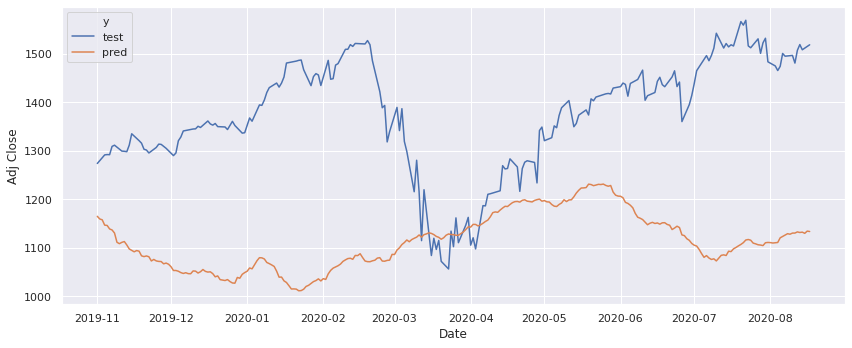

In [7]:
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R^2: {r2_score(y_test, y_pred)}")

df = pd.DataFrame({dt: df_test[dt].values, "test": y_test, "pred": y_pred})

plt.figure(figsize=(12, 5))
sns.lineplot(x=dt, y=target, hue="y", data=df.melt(dt, var_name="y", value_name=target))
plt.tight_layout()
plt.show()

In [8]:
ray_ctx.stop()